# Exploratory Analysis & Sector Correlation Studies

## 1. Import Packages and Setup Config

In [3]:
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Config
DB_PATH = "../data/data.db"
PRICES_CSV = "../data/processed/prices_monthly.csv"
FEATURES_CSV = "../data/processed/features_monthly.csv"
MACRO_CSV = "../data/processed/macro_monthly.csv"

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

## 2. Load Data

In [ ]:
def read_table(db_path: str, table: str, csv_fallback: str) -> pd.DataFrame:
    try:
        with sqlite3.connect(db_path) as conn:
            df = (pd.read_sql(f"SELECT * FROM {table}", conn, parse_dates=["date"])
                    .set_index("date")
                    .sort_index())
        print(f"Loaded '{table}' from SQLite DB at: {db_path}")
        return df
    except Exception as e:
        print(f"SQLite load failed for '{table}' ({e}); trying CSV fallback: {csv_fallback}")
        df = (pd.read_csv(csv_fallback, parse_dates=["date"])
                .set_index("date")
                .sort_index())
        print(f"Loaded '{table}' from CSV file at: {csv_fallback}")
        return df

prices = read_table(DB_PATH, "prices_monthly", PRICES_CSV)
features = read_table(DB_PATH, "features_monthly", FEATURES_CSV)
macro = read_table(DB_PATH, "macro_monthly", MACRO_CSV)

prices.head(), features.head(), macro.head()


Loaded 'prices_monthly' from SQLite DB: ../data/data.db
Loaded 'features_monthly' from SQLite DB: ../data/data.db
Loaded 'macro_monthly' from SQLite DB: ../data/data.db


(                 XLF        XLK        XLE        XLV        XLI        XLP  \
 date                                                                          
 2010-01-31  8.706627  16.942184  32.489178  23.933510  20.354637  17.178879   
 2010-02-28  9.013629  17.532255  33.466843  24.025326  21.440014  17.723101   
 2010-03-31  9.815747  18.731415  34.409573  24.666172  23.303783  18.390797   
 2010-04-30  9.944981  18.966572  35.839310  23.706545  24.295914  18.193266   
 2010-05-31  9.034174  17.547516  31.735531  22.163473  22.080416  17.350435   
 
                   XLY        XLB        XLU  XLRE        SPY  
 date                                                          
 2010-01-31  23.817570  21.497135  17.131315   NaN  80.809425  
 2010-02-28  25.143969  22.467140  16.905064   NaN  83.330254  
 2010-03-31  27.106930  24.245672  17.359909   NaN  88.403412  
 2010-04-30  28.741259  24.295715  17.816433   NaN  89.770988  
 2010-05-31  26.718981  21.979795  16.833136   NaN  82

## 3. Monthly Return by Sector

,count,mean,std,min,25%,50%,75%,max
XLF,180.0,0.0114,0.0550,-0.2104,-0.0238,0.0206,0.0478,0.1685
XLK,180.0,0.0158,0.0504,-0.1197,-0.0150,0.0186,0.0478,0.1374
XLE,180.0,0.0086,0.0779,-0.3437,-0.0303,0.0137,0.0451,0.3076
XLV,180.0,0.0108,0.0391,-0.0935,-0.0163,0.0128,0.0380,0.1259
XLI,180.0,0.0120,0.0520,-0.1863,-0.0165,0.0119,0.0422,0.1603
XLP,180.0,0.0091,0.0346,-0.0891,-0.0139,0.0131,0.0319,0.1045
XLY,180.0,0.0141,0.0536,-0.1491,-0.0131,0.0132,0.0448,0.1888
XLB,180.0,0.0094,0.0555,-0.1648,-0.0240,0.0115,0.0423,0.1734
XLU,180.0,0.0092,0.0412,-0.1128,-0.0174,0.0129,0.0377,0.1055
XLRE,111.0,0.0070,0.0512,-0.1511,-0.0254,0.0114,0.0400,0.1248


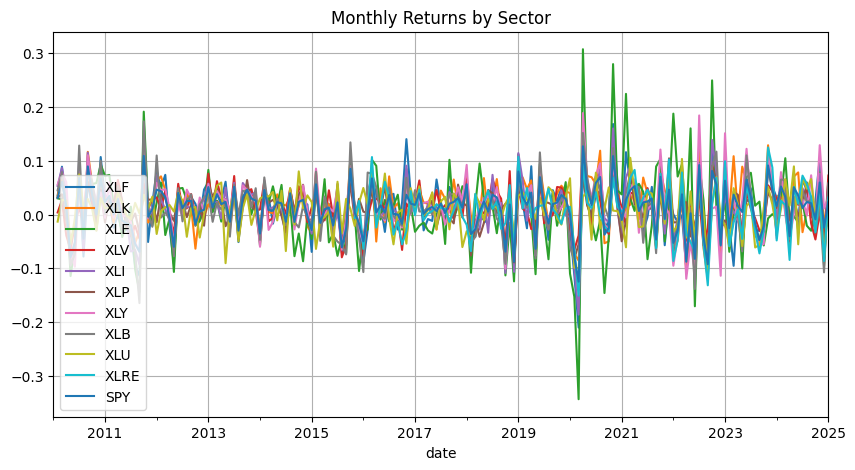

In [7]:
# Monthly Return by Sector
returns = prices.pct_change()
display(returns.describe().T.round(4))
# Plot a subset (or all) of sector return series
returns.plot(title="Monthly Returns by Sector")
plt.show()

The plot shows that most U.S. sector ETFs move closely together, indicating strong market-wide correlation driven by common factors. Defensive sectors such as XLU and Consumer Staples (XLP) exhibit the smallest fluctuations, while cyclical sectors like Energy (XLE) and Technology (XLK) show larger swings, reflecting higher sensitivity to macroeconomic changes. 

The sharp drop and rebound around 2020 correspond to the COVID-19 crash and recovery, while the increased amplitude of returns after 2021 highlights the volatility during the inflation and rate-hike period. 

Overall, SPY tracks near the sector average, confirming its role as the broad market benchmark.

## 4. Sector Correlation

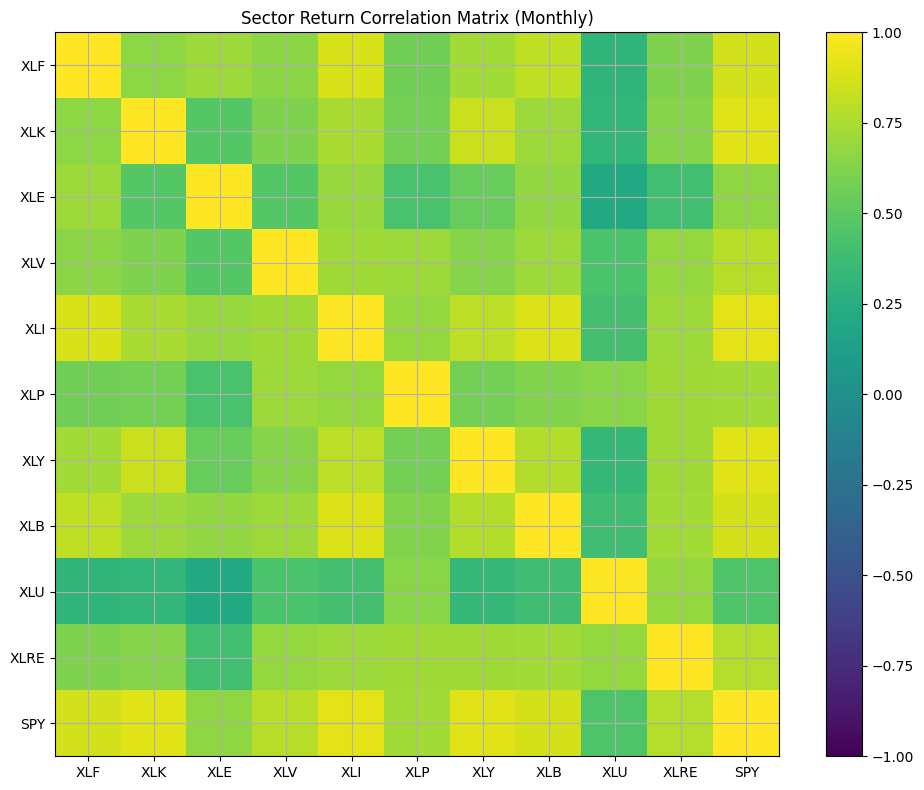

In [12]:
corr = returns.corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_title("Sector Return Correlation Matrix (Monthly)")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.index)
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

This correlation matrix shows that nearly all sectors have strong positive correlations with each other, generally ranging between 0.5 and 0.9, which reflects the broad market’s tendency to move in unison. 

The bright yellow cells along the off-diagonal indicate particularly high correlations (e.g., between Technology （XLK）, Consumer Discretionary [XLY], and Financials [XLF]), all of which are cyclical sectors that respond similarly to economic growth. Conversely, cooler green-blueareas such as those involving Energy [XLE] or Utilities [XLU] indicate weaker correlations, suggesting these sectors behave somewhat independently—Energy often diverges due to commodity price shocks, and Utilities act as a defensive hedge. 

SPY, as expected, is highly correlated with all sectors since it represents the aggregate market. Overall, the matrix confirms that sector performance is heavily synchronized, with only a few defensive or commodity-linked exceptions providing diversification.